# OLG

In [23]:
%load_ext autoreload
%autoreload 2

import numpy as np
from modelproject import OLGModelClass
from scipy import optimize
from modelproject import simulate_before_s, simulate_after_s, find_s_bracket, calc_euler_error
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interact_manual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The OLG Model


**(i) The household's maximisation problem**
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\mathbb{E}[p_{t}]\cdot\beta\frac{C_{2t+1}^{1-\sigma}}{1-\sigma},\,\,\,0 < p < 1, \beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}N_{t}\\
 & C_{1t}=(1-s_{t})(1-\tau_{w})w_{t}N_{t}\\
 & C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}
\end{aligned}
$$
    


where:

 $C_1t$ is the consumption at period t

 $C_{2t+1}$ is the consumption at period t+1
  
 $w_{t}$ is the wage

 $r_{t+1}$ is the interest rate
  
 $\mathbb{E}[p_{t}]$ is the expected survival probability
  
 $\beta$ is the discount factor , 0<$\beta$ < 1 


**(ii) The production function**   
$$
\begin{aligned}
Y_{t}=F(K_{t-1},L_{t})=(\alpha K_{t-1}^{-\theta}+(1-\alpha)L_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1)
\end{aligned}
$$
    

Profits:    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}




**(iii) Population:**
Labour force:
$$
\begin{aligned}
Pop^{young}_{t+1}=L_{t+1} = (1 + n)  L_t
\end{aligned}
$$
Old generation:
$$
\begin{aligned}
Pop^{old}_{t+1}=p_{t}\cdot Pop^{young}_{t}
\end{aligned}
$$

**(iv) Capital:**
$$
\begin{aligned}
K_{t+1} = (1+\delta)K_t+I_t
\end{aligned}
$$

**(v) Euler Condition**


$$
\begin{aligned}
C_{1t}^{-\sigma}=\mathbb{E}[p_t]\cdot\beta(1+\tilde{r}_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

### The OLG-model with an Increasing Population and Non-Zero Probability of Premature Death

We explore the link between the OLG model's population dynamics and COVID-19 by extending the model to include the impact of the pandemic on population growth rates and survival probabilities.Effectively this means that the probability of surviving is just an additional discount rate.
The surviival probability has been intially set to 95% for all periods (with population size increrasing by 2% in each period) to imply times before the pandemic hit.

### Solving the Model

The OLGModelClass uses a lot of the same code as in the lecture notes, with some modifications to take the population size into consideration as well as the survival expectations. Firstly it updates the population, then it calculates the total income $(Y)$ as well as the interest rate, wage, consumption in the next period for the then old generation, and government income- and expenditure. Afterwards it then calculates the savings rate that satisfies the Euler condition, and following this it calculates the consumption in the period for the young generation as well as the investments and therefore also the capital level.

# Population Growth

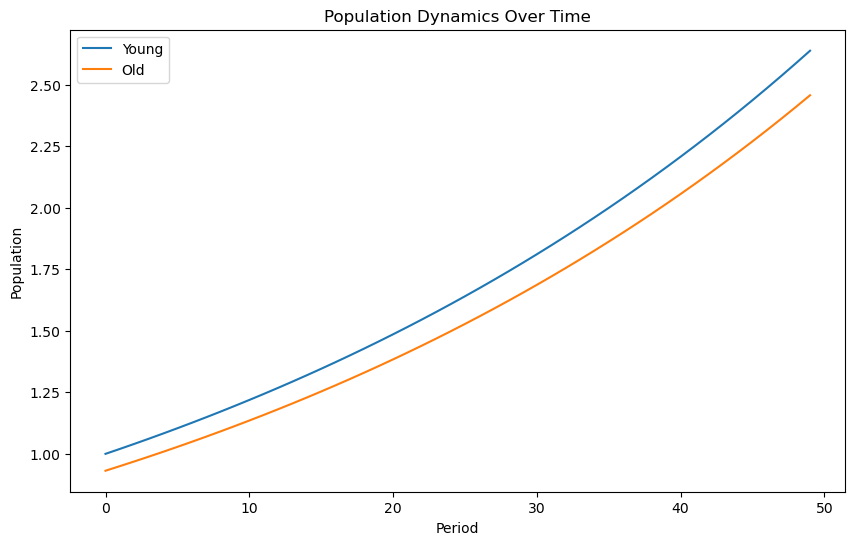

In [24]:
# a. create and simulate the model
model = OLGModelClass(do_print=False)
par = model.par
sim = model.sim

p = 0.95 # survival probability
par.n = 0.02 # population growth
par.p = np.full(par.simT, p) 
par.exp_p = np.concatenate(([0.95], par.p)) # static expected survival probability in period t which is equal to that of period t-1 

model.simulate(do_print=False)


# b. plot the populations over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.par.pop_young, label="Young")
plt.plot(range(model.par.simT), model.par.pop_old, label="Old")
plt.xlabel("Period")
plt.ylabel("Population")
plt.legend()
plt.title("Population Dynamics Over Time")
plt.show()

In the figure above we observe a constant exponential growth for both the young and old generation.

# Euler Condition

In [25]:
sum_sq_error = 0
for t in range(par.simT-1):
    LHS = sim.C1[t]**(-par.sigma)
    RHS = par.exp_p[t] * (1+sim.rt[t+1])*par.beta * sim.C2[t+1]**(-par.sigma)
    error = LHS-RHS
    sum_sq_error += error**2
print(f'Sum of squared errors: {sum_sq_error:.5f}')

Sum of squared errors: 0.00000


The Euler condition holds for all the periods.

# Capital

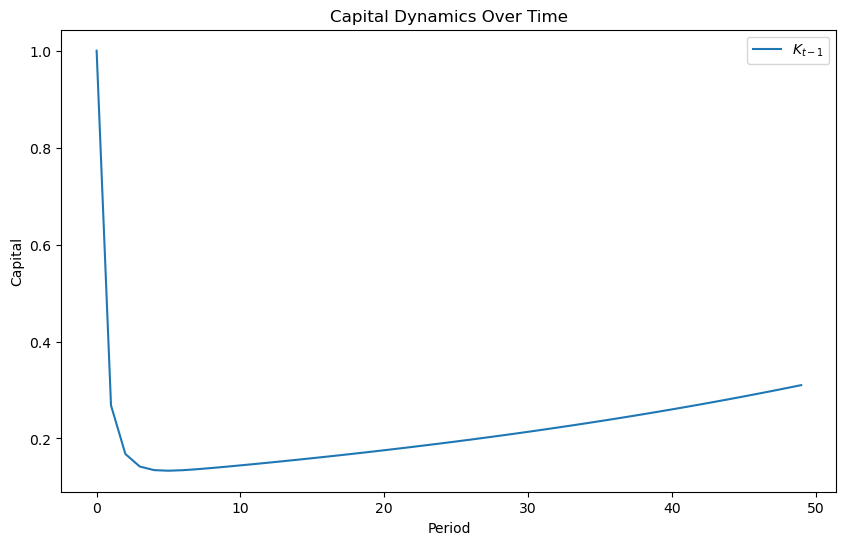

In [26]:
# a. plot the lagged capital over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag, label=r"$K_{t-1}$")
plt.xlabel("Period")
plt.ylabel("Capital")
plt.legend()
plt.title("Capital Dynamics Over Time")
plt.show()


In the figure above we see how capital starts by decreasing sharply to reach its steady state growth path. Following that the constant increase in the capital level is caused by the increasing population size.

# Capital Share of Income

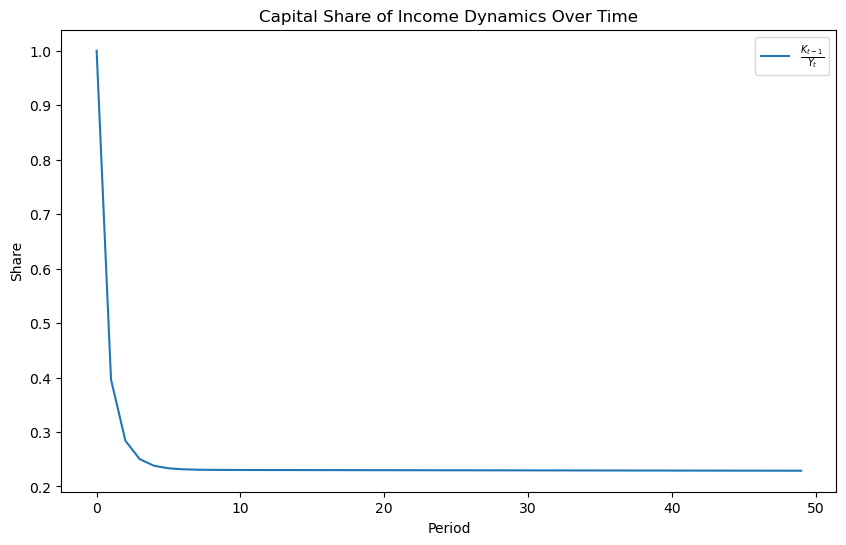

In [27]:
# a. plot the lagged capital share of income over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"$\frac{K_{t-1}}{Y_t}$")
plt.xlabel("Period")
plt.ylabel("Share")
plt.legend()
plt.title("Capital Share of Income Dynamics Over Time")
plt.show()

In the figure above we observe almost the same as the previous figure: capital's share of the total income starts by decreasing sharply reaching its steady state level. Following that it is completely flat unlike the previous figure. The reason for it being flat in this figure and not in the previous figure is because income also increase with the population size. Nothing else happens as no shocks or any changes happens to the economy.

# Comparative Statistics

In [28]:
def plot_capital(sigma, beta, alpha, theta, delta, tau_w, tau_r):
    # update parameters
    par.sigma = sigma
    par.beta = beta
    par.alpha = alpha
    par.theta = theta
    par.delta = delta
    par.tau_w = tau_w
    par.tau_r = tau_r

    model.simulate(do_print=False)
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"$\frac{K_{t-1}}{Y_t}$")
    plt.xlabel("Period")
    plt.ylabel("Share")
    plt.legend()
    plt.title("Capital Share of Income Dynamics Over Time")
    plt.show()

# create widgets
sigma_widget = widgets.FloatSlider(min=0.1, max=5.0, step=0.01, value=2.0)
beta_widget = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.40)
alpha_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.3)
theta_widget = widgets.FloatSlider(min=-1.0, max=0.3, step=0.01, value=0.05)
delta_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.50)
tau_w_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.10)
tau_r_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.20)

# call interact
interact(plot_capital, sigma=sigma_widget, beta=beta_widget, alpha=alpha_widget, 
         theta=theta_widget, delta=delta_widget, tau_w=tau_w_widget, tau_r=tau_r_widget);


interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0, min=0.1, step=0.01), FloatSlider(va…

In the figure above, you can see how changing the parameters affects capital's share of income. Notice that sometimes it may not look like the curve changes when changing the values, but the second axis changes.

# Pandemic

The survival probability has been set to 95% for all periods by default.From periods 10 to 20, the probability has been adjusted to 0.6 

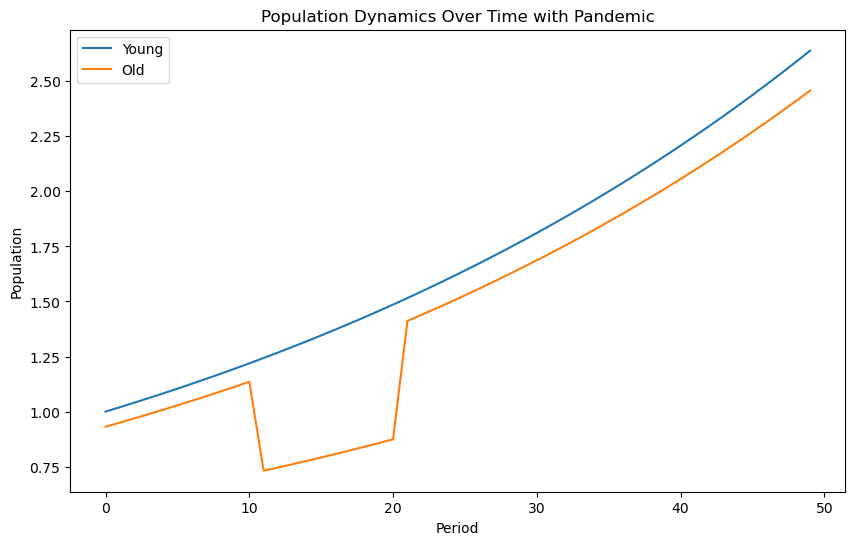

In [29]:
# a. create and simulate the model
model = OLGModelClass(do_print=False)
par = model.par
sim = model.sim 

p = 0.95 # survival probability
par.n = 0.02 # population growth
par.p = np.full(par.simT, p) 
par.p[10:20] = 0.6 # temporary pandemic decreases the survival probability
par.exp_p = par.exp_p = np.concatenate(([0.95], par.p)) # static expected survival probability in period t+1 which is equal to that of period t 

model.simulate(do_print=False)

# b. plot the populations over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.par.pop_young, label="Young")
plt.plot(range(model.par.simT), model.par.pop_old, label="Old")
plt.xlabel("Period")
plt.ylabel("Population")
plt.legend()
plt.title("Population Dynamics Over Time with Pandemic")
plt.show()


In the figure above we observe no change for the young generation compared to the first figure of the population, but we do see a dramatic drop in the old generation caused by the decreased probability of survival caused by the pandemic.

# Euler Condition

In [30]:
sum_sq_error = 0
for t in range(par.simT-1):
    LHS = sim.C1[t]**(-par.sigma)
    RHS = par.exp_p[t] * (1+sim.rt[t+1])*par.beta * sim.C2[t+1]**(-par.sigma)
    error = LHS-RHS
    sum_sq_error += error**2
print(f'Sum of squared errors: {sum_sq_error:.5f}')

Sum of squared errors: 0.00000


Since the Euler condition depends on the expected survival probability the Euler condition still holds for all periods.

# Capital

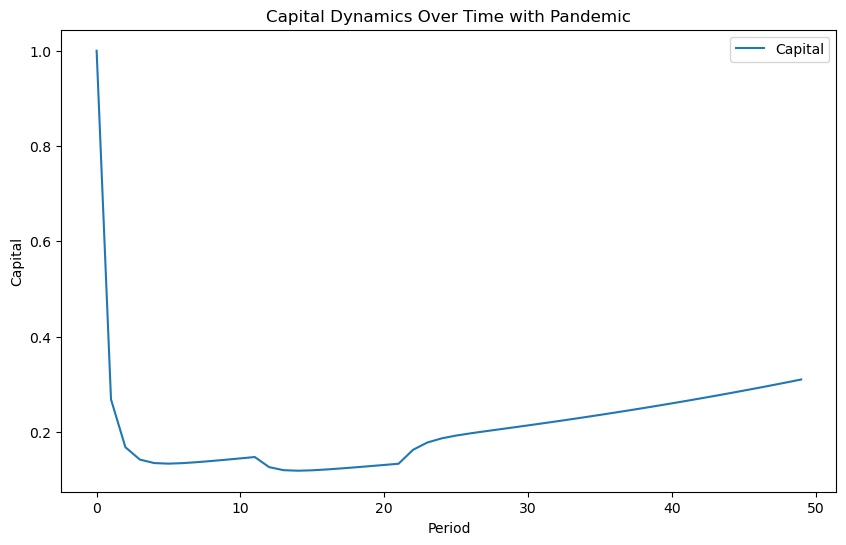

In [31]:
# a. plot the lagged capital over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag, label="Capital")
plt.xlabel("Period")
plt.ylabel("Capital")
plt.legend()
plt.title("Capital Dynamics Over Time with Pandemic")
plt.show()


In the figure above we see, that the only difference before and after the pandemic happens during the pandemic and shortly afterwards when the level of capital approaches its previous growth path. When the expected probability of survival decreases, it decreases the incentive to save, since the probability of you being able to spend your savings has decreased. Notice

# Capital Share of Income

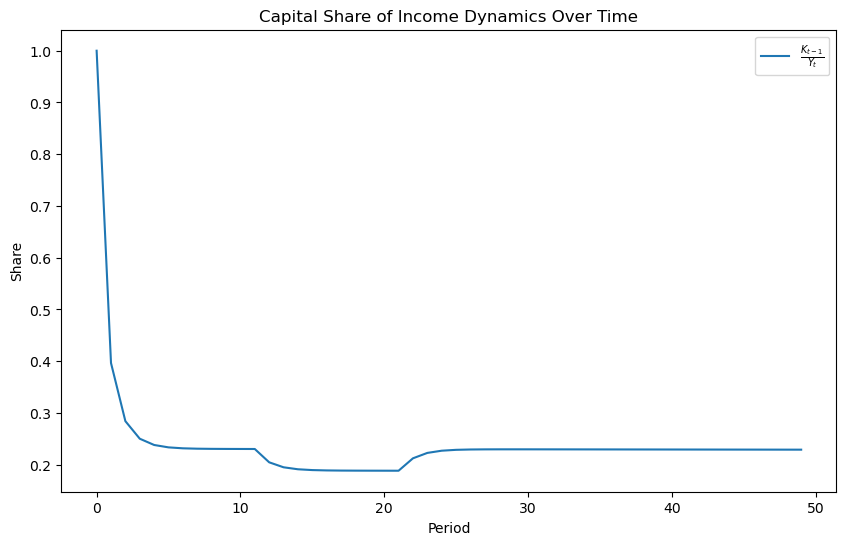

In [32]:
# a. plot the lagged capital share of income over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"$\frac{K_{t-1}}{Y_t}$")
plt.xlabel("Period")
plt.ylabel("Share")
plt.legend()
plt.title("Capital Share of Income Dynamics Over Time")
plt.show()

Since the working/young generation are not affected (or do not die) capital's share of the income decreases during the pandemic because the total income stays unchanged.

# Comparative Statistics

In [33]:
def plot_capital(sigma, beta, alpha, theta, delta, tau_w, tau_r):
    # update parameters
    par.sigma = sigma
    par.beta = beta
    par.alpha = alpha
    par.theta = theta
    par.delta = delta
    par.tau_w = tau_w
    par.tau_r = tau_r

    model.simulate(do_print=False)
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"$\frac{K_{t-1}}{Y_t}$")
    plt.xlabel("Period")
    plt.ylabel("Share")
    plt.legend()
    plt.title("Capital Share of Income Dynamics Over Time")
    plt.show()

# create widgets
sigma_widget = widgets.FloatSlider(min=0.1, max=5.0, step=0.01, value=2.0)
beta_widget = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.40)
alpha_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.3)
theta_widget = widgets.FloatSlider(min=-1.0, max=0.3, step=0.01, value=0.05)
delta_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.50)
tau_w_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.10)
tau_r_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.20)

# call interact
interact(plot_capital, sigma=sigma_widget, beta=beta_widget, alpha=alpha_widget, 
         theta=theta_widget, delta=delta_widget, tau_w=tau_w_widget, tau_r=tau_r_widget);


interactive(children=(FloatSlider(value=2.0, description='sigma', max=5.0, min=0.1, step=0.01), FloatSlider(va…

In the figure above, you can see how changing the parameters affects capital's share of income. Notice that sometimes it may not look like the curve changes when changing the values, but the second axis changes.